In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [3]:
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    x_norm = (x - mean) / std
    return x_norm

def standardize(x):
    m = max(x)
    return x/m

def replace_outliers_zscore(x, threshold=3):
    z = np.abs((x - np.mean(x)) / np.std(x))
    x_filtered = x.copy()
    x_filtered[z >= threshold] = np.median(x)
    return x_filtered

def average_window(signal, averaging_method=np.average):
    window_size = 37
    moving_averages = []
    for i in range(window_size, len(signal) + 1, window_size):
        window = signal[i-window_size:i]
        
        avg = averaging_method(window)
        
        moving_averages.append(avg)
    return np.array(moving_averages)

class Configuration:
    def __init__(self, root, scaling, dataRange):
        self.root = root
        self.raw = r"/".join([root, "raw"])
        self.processed = r"/".join([root, "processed"])
        self.scaling = scaling
        self.dr = dataRange
        self.csv_name = "Gabe_5min_walk1.csv"

config = Configuration(root="datasets", scaling=10000, dataRange= slice(125, -325))

### Old Solution

In [7]:
csvList = [i for i in os.listdir(config.raw) if i.split(".")[-1] == "csv"]
new_csv = {}
for j, file in enumerate(csvList):
    file_path = r"/".join([config.raw, file])
    
    df = pd.read_csv(file_path)
    EMGS = (df.iloc[config.dr, 1::20] * config.scaling)
    time = df.iloc[config.dr, 0]
    
    
    for i, column in enumerate(EMGS.columns):
        
        nEmg = EMGS[column].values    
        
        nEmg = replace_outliers_zscore(EMGS[column], threshold=4)
        nEmg = average_window(nEmg, np.mean)
        nEmg = normalize(nEmg)
        
        nEmg = abs(nEmg)
        
        nEmg = standardize(nEmg)
        
        if column in new_csv.keys():
            new_csv[column] = np.append(new_csv[column], nEmg)
        else:
            new_csv[column] = nEmg
            
        
    print(r"/".join([config.processed, file]))
    
pd.DataFrame(new_csv).to_csv(r"/".join([config.processed, "total.csv"]), index=False)

datasets/processed/10_min_1.csv
datasets/processed/10_min_2.csv
datasets/processed/5_min_1.csv


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### New Solution

In [36]:
new_csv = {}
file_path = r"/".join([config.raw, config.csv_name])
df = pd.read_csv(file_path)
df = df.drop(df.columns[0::2], axis=1)
display(df)
new_csv = {}

for i, column in enumerate(df.columns):
    print(column)

    nEmg = df[column].values    

    nEmg = replace_outliers_zscore(nEmg, threshold=4)
    print(len(nEmg))
    nEmg = average_window(nEmg, np.mean)
    print(len(nEmg))
    nEmg = normalize(nEmg)
    print(len(nEmg))

    nEmg = abs(nEmg)
    print(len(nEmg))

    nEmg = standardize(nEmg)
    print(len(nEmg))

    new_csv[column] = nEmg
    break

new_csv = pd.DataFrame(new_csv) # .to_csv(r"/".join([config.processed, "total.csv"]), index=False)
display(new_csv)

,L_Quad: EMG 1 (IM) [V],L_Quad: Acc 1.X (IM) [g],L_Quad: Acc 1.Y (IM) [g],L_Quad: Acc 1.Z (IM) [g],L_Quad: Gyro 1.X (IM) [°/s],L_Quad: Gyro 1.Y (IM) [°/s],L_Quad: Gyro 1.Z (IM) [°/s],L_Quad: Mag 1.X (IM) [uT],L_Quad: Mag 1.Y (IM) [uT],L_Quad: Mag 1.Z (IM) [uT],...,R_Calf: EMG 8 (IM) [V],R_Calf: Acc 8.X (IM) [g],R_Calf: Acc 8.Y (IM) [g],R_Calf: Acc 8.Z (IM) [g],R_Calf: Gyro 8.X (IM) [°/s],R_Calf: Gyro 8.Y (IM) [°/s],R_Calf: Gyro 8.Z (IM) [°/s],R_Calf: Mag 8.X (IM) [uT],R_Calf: Mag 8.Y (IM) [uT],R_Calf: Mag 8.Z (IM) [uT]
0,0.000000,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36998,-0.000032,0.1300,-1.53,-0.952,-126.0,-128.0,-42.9,NaN,NaN,NaN,...,-0.000012,-0.261,-1.58,-0.255,76.2,92.1,-122.0,NaN,NaN,NaN
36999,-0.000033,0.3670,-1.67,-0.626,-151.0,-132.0,-17.3,NaN,NaN,NaN,...,-0.000008,-0.421,-1.61,-0.316,79.6,111.0,-124.0,NaN,NaN,NaN
37000,-0.000027,0.3570,-1.67,-0.286,-114.0,-75.7,12.6,NaN,NaN,NaN,...,-0.000007,-0.563,-1.63,-0.365,80.6,120.0,-124.0,NaN,NaN,NaN
37001,-0.000033,0.2490,-1.61,-0.178,-47.4,16.1,38.2,NaN,NaN,NaN,...,-0.000010,-0.627,-1.65,-0.368,78.6,124.0,-123.0,NaN,NaN,NaN


L_Quad: EMG 1 (IM) [V]
37003
1000
1000
1000
1000


,L_Quad: EMG 1 (IM) [V]
0,0.065182
1,0.065182
2,0.052237
3,0.103564
4,0.016649
...,...
995,0.091072
996,0.271838
997,0.270461
998,0.214511


[]

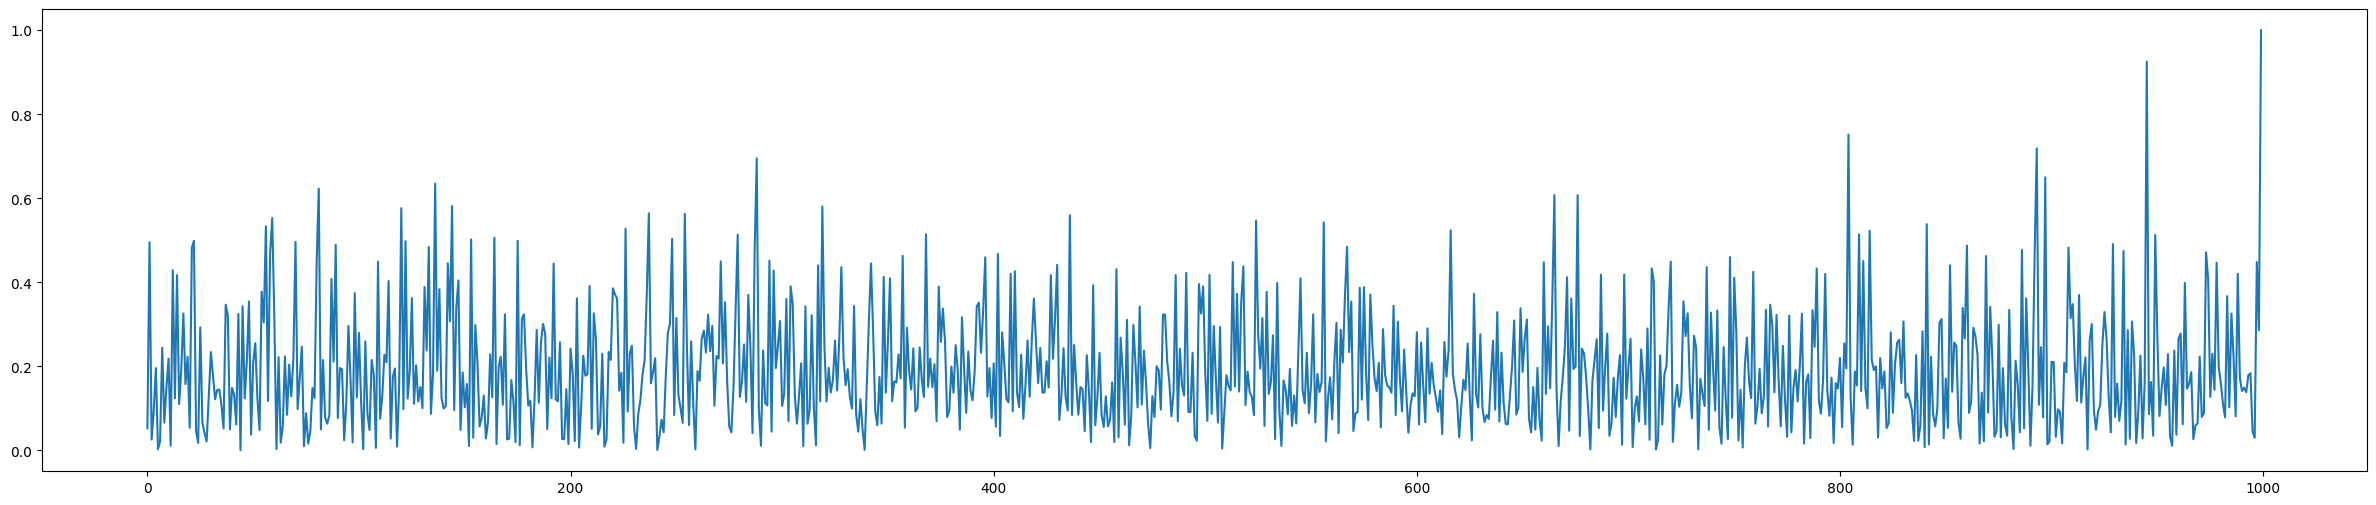

In [34]:
plt.figure(figsize=(30, 6), dpi=100)
# print(df.iloc[:,0].values)
plt.plot(new_csv.iloc[:,1].values)
plt.plot()

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[0]])
plt.plot(new_csv[list(new_csv.keys())[4]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[1]])
plt.plot(new_csv[list(new_csv.keys())[5]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[2]])
plt.plot(new_csv[list(new_csv.keys())[6]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[3]])
plt.plot(new_csv[list(new_csv.keys())[7]])